# Data

* weekday
* weekends
* season of the year
* highlight old data
* highlight abnormal periods
* beginning/end of month
* payday

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
%matplotlib inline

data = pd.read_csv('../../Data/taxi/train.csv')
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

y = data["trip_duration"]
X = data.drop(columns=["trip_duration"])

In [18]:
data['day_of_year'] = data['pickup_datetime'].dt.dayofyear
data['month_of_year'] = data['pickup_datetime'].dt.month
data['day_of_week'] = data['pickup_datetime'].dt.dayofweek
data['is_weekend'] = data['pickup_datetime'].apply(lambda x: 1 if x.date().weekday() in (5, 6) else 0)

In [19]:
dict_seasons = {0:'winter', 1:'winter', 2:'spring', 3:'spring', 4:'spring', 5:'summer', 6:'summer'}

data['season'] = data['month_of_year'].apply(lambda x: dict_seasons[x])

# Time

* period of the day
* rush hours
* simple encoding
* harmonic encoding

In [20]:
data['hour_of_day'] = data['pickup_datetime'].dt.hour

**Rush hours, free hours**

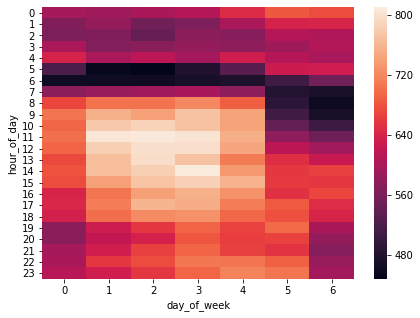

In [21]:
df4 = pd.DataFrame(data.groupby(['day_of_week', 'hour_of_day']).median()['trip_duration']).reset_index()


fig, ax = plt.subplots(figsize=(7,5))

sns.heatmap(df4.pivot(columns='day_of_week',index='hour_of_day',values='trip_duration'), ax=ax);

In [22]:
data['traffic_jams'] = np.where(((data['day_of_week'] == 0) & (data['hour_of_day'] >= 7) & (data['hour_of_day'] <= 19)) | 
         ((data['day_of_week'] == 1) & (data['hour_of_day'] >= 7) & (data['hour_of_day'] <= 21)) | 
         ((data['day_of_week'] == 2) & (data['hour_of_day'] >= 7) & (data['hour_of_day'] <= 22)) | 
         ((data['day_of_week'] == 3) & (data['hour_of_day'] >= 7) & (data['hour_of_day'] <= 23)) | 
         ((data['day_of_week'] == 4) & (data['hour_of_day'] >= 7) & (data['hour_of_day'] <= 24)) |          
         ((data['day_of_week'] == 5) & (data['hour_of_day'] >= 10) & (data['hour_of_day'] <= 24))| 
         ((data['day_of_week'] == 5) & (data['hour_of_day'] == 0)) | 
         ((data['day_of_week'] == 6) & (data['hour_of_day'] >= 13) & (data['hour_of_day'] <= 18))| 
         ((data['day_of_week'] == 6) & (data['hour_of_day'] == 0)), 1,0)


data['free_roads'] = np.where(((data['day_of_week'] == 0) & (data['hour_of_day'] >= 4) & (data['hour_of_day'] <= 5)) | 
         ((data['day_of_week'] == 1) & (data['hour_of_day'] >= 3) & (data['hour_of_day'] <= 5)) | 
         ((data['day_of_week'] == 2) & (data['hour_of_day'] >= 4) & (data['hour_of_day'] <= 5)) | 
         ((data['day_of_week'] == 3) & (data['hour_of_day'] >= 3) & (data['hour_of_day'] <= 5)) | 
         ((data['day_of_week'] == 4) & (data['hour_of_day'] == 5)) |          
         ((data['day_of_week'] == 5) & (data['hour_of_day'] >= 5) & (data['hour_of_day'] <= 6)) | 
         ((data['day_of_week'] == 6) & (data['hour_of_day'] >= 5) & (data['hour_of_day'] <= 8)), 1,0)

**Harmonic time encoder**

Problem of simpe encoding is distance between 23:00 and 1:00 at night, for example. It can be solved with following approach.

In [25]:
def make_harmonic_features(value, period=24):
    value *= 2 * np.pi / period
    return np.cos(value), np.sin(value)

In [28]:
from scipy.spatial import distance

distance.euclidean(make_harmonic_features(23), make_harmonic_features(1))

0.5176380902050423

In [29]:
distance.euclidean(make_harmonic_features(9), make_harmonic_features(11))

0.5176380902050414

In [30]:
distance.euclidean(make_harmonic_features(9), make_harmonic_features(21))

2.0

# Time series

* Time series lags
* Window statistics:
    - Max/min value of series in a window
    - Average/median value in a window
    - Window variance
    - etc.
* Date and time features:
    - Minute of an hour, hour of a day, day of the week, and so on
    - Is this day a holiday? Maybe there is a special event? Represent that as a boolean feature
* Target encoding 
* Forecasts from other models (note that we can lose the speed of prediction this way)

[Library for automatic feature extraction from time series](https://github.com/blue-yonder/tsfresh) 

In [4]:
ads = pd.read_csv('../../Data/ads_timeseries.csv', index_col=['Time'], 
                  parse_dates=['Time'])

In [20]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data.index = pd.to_datetime(data.index)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

        # drop encoded variables 
        data.drop(["hour", "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [18]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

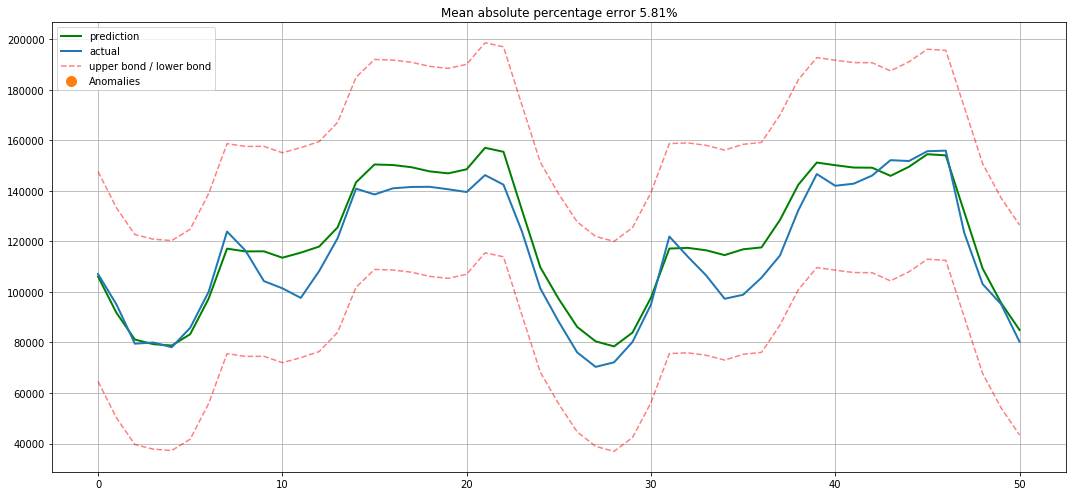

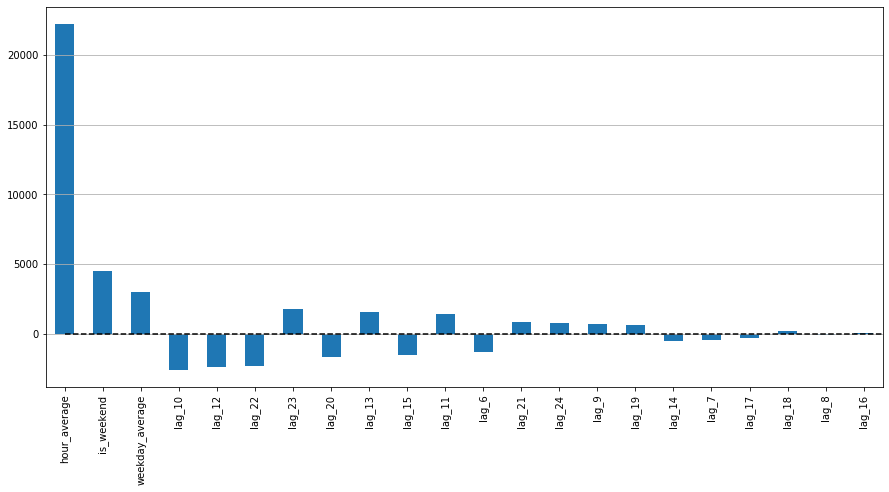

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

scaler = StandardScaler()
tscv = TimeSeriesSplit(n_splits=5)

X_train, X_test, y_train, y_test =\
prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)